In [1]:
"""
Check all datasets
"""
%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')
from ipywidgets import interact
from ipywidgets import Controller

from collections import defaultdict
import numpy as np
import os
import sys
import itertools
from tqdm import tqdm
import pandas as pd
from pprint import pprint
import regex as re
sys.path.append('/export/home/asanakoy/workspace/neural_network')
sys.path.append('/export/home/asanakoy/workspace/art_datasets')
sys.path.append('/export/home/asanakoy/workspace/dataset_merger')
import make_data.dataset
import wikiart.info.preprocess_info
from art_utils.pandas_tools import is_null_object
from art_utils.text_tools import extract_all_years
import dataset_merger.read_datasets
import dataset_merger.pymongoext as pymongoext
from dataset_merger.match_artists import fix_sim_matrix
from dataset_merger.match_artists import generate_matches_for_manual_check
from dataset_merger.match_artists import get_num_top_matches
from dataset_merger.match_artists import compute_sim_matrix
from dataset_merger.match_artists import find_connected_components
from dataset_merger.match_artists import combine_artists
from dataset_merger.match_artists import get_merged_artists_df
import dataset_merger.prepare_artists as prepare_artists
from dataset_merger.prepare_artists import get_artists_with_years

pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 50)  
pd.set_option('display.max_columns', None) 

# todo: merge wga, wikiart, artuk, googleart (dates checked)
# todo: make uniform dates (bio or active if no bio available) range for every artist in the dataset

# todo: check dates on others
# todo: chach should we split naems on `&` for other datasets (beyound artuk, wikiart, googleart, wga)
# TOD: manually check connected components (wga, artuk) 

In [27]:
dfs = dataset_merger.read_datasets.read_datasets()

artuk
artuk 207585
googleart
googleart 105963
moma
moma 25872
rijks
rijks 96189
wga
wga 35884
wiki
wiki 132296
meisterwerke
meisterwerke 19647
Total works count: 623436
time: 10.7 s


In [3]:
# for key, df in dfs.iteritems():
#     print key
#     print df.columns
#     print '==='
    

# print '--'
# artist_names = np.unique(artist_names)
# print 'Total unique artists num:', len(artist_names)
# return artist_names

time: 2.09 ms


In [5]:
artists_with_years_dict = dict()
artists_with_years_dict['googleart'] = get_artists_with_years('googleart', dfs)
artists_with_years_dict['wiki'] = get_artists_with_years('wiki', dfs)
artists_with_years_dict['wga'] = get_artists_with_years('wga', dfs)
# artists_with_years_dict['artuk'] = get_artists_with_years('artuk', dfs)
artists_with_years_dict['meisterwerke'] = get_artists_with_years('meisterwerke', dfs)



100%|██████████| 4445/4445 [00:00<00:00, 57594.13it/s]

with url_wiki: 3202
4445
4380



100%|██████████| 2276/2276 [00:00<00:00, 52885.98it/s]


2276
2270


100%|██████████| 4727/4727 [00:00<00:00, 59072.06it/s]


4727
4727
2294
2182
Discarded 17 unknown artists
time: 2.98 s


In [6]:
# artcyclopedia_artists = pymongoext.get_db_entries('129.206.117.36', 27017, 'artcyclopedia', 'found')
# for x in artcyclopedia_artists:
#     x['artcylopedia_name'] = x['name']
#     del x['name']
#     del x['_id']
#     if 'content' in x:
#         del x['content']
# print len(artcyclopedia_artists)
# print artcyclopedia_artists[:2]

# artcyclopedia_df = pd.DataFrame.from_dict(artcyclopedia_artists)
# artcyclopedia_df.index = artcyclopedia_df['artist_name']
# artcyclopedia_df.rename(columns={'url': 'url_artcyclopedia'}, inplace=True)

# # artists_df['url_artcyclopedia'] = artcyclopedia_df.loc[artist_names, 'url_artcyclopedia'].values
# # print pd.notnull(artists_df['url_artcyclopedia']).sum()
# print len(artcyclopedia_df)
# print len(artcyclopedia_df['url_artcyclopedia'].unique())


# artcyclopedia_df

time: 5.8 ms


In [7]:
def get_sim_matrix(dataset_names, shape=None, force=False, n_jobs=1):
    assert len(dataset_names) == 2
    str_name = '-'.join(dataset_names)
    matrix_filepath = 'sim_matrix_{}.npy'.format(str_name)
    if os.path.exists(matrix_filepath) and not force:
        sim = np.load(matrix_filepath)
        if shape is not None:
            assert shape == sim.shape, '{} != {}'.format(shape, sim.shape)
    else:
        sim = compute_sim_matrix(keys, artists_with_years_dict, n_jobs=n_jobs)
        np.save(matrix_filepath, sim)
        print 'Sim matrix saved to {}'.format(matrix_filepath)
    return sim

def get_sim_matrix_and_plot(dataset_names, force=False, n_jobs=1):
    str_name = '-'.join(dataset_names)
    print str_name
    shape = tuple([len(artists_with_years_dict[dataset_names[i]]) for i in xrange(2)])
    sim_matrix[str_name] = get_sim_matrix(dataset_names, shape=shape, force=force, n_jobs=n_jobs)
    print sim_matrix[str_name].shape
    best_sim = sim_matrix[str_name].max(axis=1)
    plt.hist(best_sim)
    plt.show()

sim_matrix = dict()

time: 27.3 ms


In [8]:
def check_pairs(dataset_names, transpose=False, 
                min_sim=85, max_sim=100, 
                discard_exaclty_matched_dates=False,
                min_k=1, min_total_works_count=0):
    assert len(dataset_names) == 2
    sim = sim_matrix['-'.join(dataset_names)]
    dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

    manually_checked_matches_path = '{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
    if os.path.exists(manually_checked_matches_path):
        manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0, encoding='utf-8')
        print 'manually checked pairs:', len(manually_checked_matches_df)
        sim = fix_sim_matrix(dataset_names, 
                             dfs_to_merge, 
                             sim, 
                             manually_checked_matches_df)
    
    if transpose:
        # Transpose matches
        dataset_names = dataset_names[::-1]
        dfs_to_merge = dfs_to_merge[::-1]
        sim = sim.transpose()

    results_df = generate_matches_for_manual_check(dataset_names, dfs_to_merge, 
                                                   sim, min_sim=min_sim, max_sim=max_sim,
                                                   discard_exaclty_matched_dates=discard_exaclty_matched_dates,
                                                   min_k=min_k, 
                                                   min_total_works_count=min_total_works_count)
    output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
    results_df.to_csv(output_path, encoding='utf-8')
    return results_df

time: 24.5 ms


In [9]:
def correct_ids_in_manually_checked_matches(dataset_names):
    """
        Check each pair in manually_checked_matches and change $artist_id to one from 'artist_ids' list (if possible)
        if $artist_id is not currently in index of the artist_df
    """
    
    manually_checked_matches_path = '{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
    if not os.path.exists(manually_checked_matches_path):
        raise IOError('File {} not found'.format(manually_checked_matches_path))
    manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0, encoding='utf-8')
    print 'manually checked pairs:', len(manually_checked_matches_df)

    dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]
    
    def convert_to_valid_idx(artists_df, artist_id):
        if artist_id not in artists_df.index:
            found_idxs = np.nonzero(artists_df['artist_ids'].apply(lambda x: artist_id in x))[0]
            if len(found_idxs):
                assert len(found_idxs) == 1, '{}: {}'.format(artist_id, found_idxs)
                artist_id = artists_df.index[found_idxs[0]]
        return artist_id
        
    
    def is_valid_pairs(row):
        for i in xrange(2):
            artist_id = row['artist_id_' + dataset_names[i]]
            if artist_id not in dfs_to_merge[i].index:
                return False
        return True
    
    is_valid = manually_checked_matches_df.apply(is_valid_pairs, axis=1)
    print 'not valid before fixes:', (~is_valid).sum()
    print manually_checked_matches_df[~is_valid]
    
    for i in xrange(2):
        manually_checked_matches_df['artist_id_' + dataset_names[i]] = \
            manually_checked_matches_df['artist_id_' + dataset_names[i]] \
            .apply(lambda x: convert_to_valid_idx(dfs_to_merge[i], x))
    
    is_valid = manually_checked_matches_df.apply(is_valid_pairs, axis=1)
    print 'not valid', (~is_valid).sum()
    print manually_checked_matches_df[~is_valid]
    return manually_checked_matches_df

# dataset_names = ['wiki+googleart', 'wga']
# manually_checked_matches_df = correct_ids_in_manually_checked_matches(dataset_names)
# manually_checked_matches_path = '{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
# manually_checked_matches_df.to_csv(manually_checked_matches_path, encoding='utf-8')

time: 44.9 ms


In [10]:
# def fix_wga_ids(matches_df):
    
#     def years_range_to_suffix(years_range):
#         if not isinstance(years_range, float):
#             assert isinstance(years_range, list)
#             return ', ({}-{})'.format(*np.asarray(years_range, dtype=int))
#         else:
#             return ''
    
#     matches_df = matches_df.copy()
#     fixed_bio_df = pd.read_csv('/export/home/asanakoy/workspace/wga/info/duplicate_artists_fixed_bio.csv', encoding='utf-8', header=0)
#     for row in fixed_bio_df.itertuples():
#         new_years_bio = map(int, re.split(r',|-', row.fixed_bio.strip()))
#         mask = matches_df['artist_id_wga'] == row.artist_id
#         matches_df.loc[mask, 'dates_wga'] = matches_df.loc[mask, 'dates_wga'].apply(lambda _: new_years_bio)
#         matches_df.loc[mask, 'artist_id_wga'] = matches_df.loc[mask, 'artist_id_wga'].apply(lambda x: x.rsplit(',', 1)[0] + 
#                                                                            years_range_to_suffix(new_years_bio))
#     return matches_df

# dataset_names = ['wiki+googleart', 'wga']
# manually_checked_matches_df = fix_wga_ids(manually_checked_matches_df)
# manually_checked_matches_path = '{}_manually_corrected_matches.csv'.format('-'.join(dataset_names))
# manually_checked_matches_df.to_csv(manually_checked_matches_path, encoding='utf-8')

time: 4.45 ms


In [11]:
%autoreload

time: 183 ms


wiki-googleart


  0%|          | 0/2270 [00:00<?, ?it/s]

Num taks: 2270


100%|██████████| 2270/2270 [01:27<00:00, 26.00it/s]
[Parallel(n_jobs=16)]: Done 2270 out of 2270 | elapsed:  1.5min finished


Sim matrix saved to sim_matrix_wiki-googleart.npy
(2270, 4380)


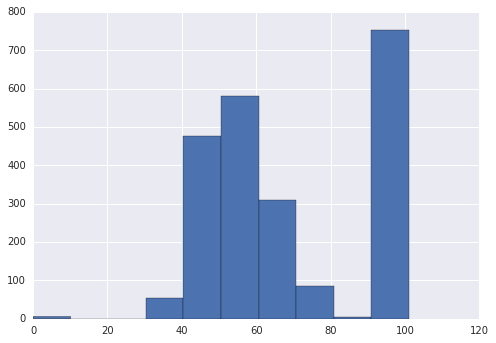

time: 1min 30s


In [12]:
keys = ['wiki', 'googleart']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

# keys = ['wga', 'artuk']
# get_sim_matrix_and_plot(keys)
    

In [13]:
check_pairs(['wiki', 'googleart'], 
            transpose=True,
            min_sim=85, max_sim=101, 
            discard_exaclty_matched_dates=False,
            min_k=1)

manually checked pairs: 70
count: 8
8


,score,names_googleart,dates_googleart,names_wiki,dates_wiki,is_same,artist_id_googleart,artist_id_wiki,idx,total_works_count
0,100.0,[nam june paik],"[1932, 2006]","[nam june paik, 백남준]","[1932, 2006]",True,m0135lv,nam-june-paik,"(138, 1604)",10
1,100.0,[enrico prampolini],"[1894, 1956]",[enrico prampolini],"[1894, 1956]",True,m04y7cfc,enrico-prampolini,"(1588, 556)",39
2,100.0,[joshua johnson],"[1763, 1832]",[joshua johnson],"[1763, 1824]",True,m052g5x,joshua-johnson,"(1643, 1222)",31
3,100.0,[kenny scharf],"[1958, 2099]",[kenny scharf],"[1958, 2099]",True,m08r5qp,kenny-scharf,"(2317, 1292)",64
4,100.0,[bruce nauman],"[1941, 2099]",[bruce nauman],"[1941, 2099]",True,m0d97b,bruce-nauman,"(2740, 286)",8
5,100.0,[ding yanyong],"[1902, 1978]",[ding yanyong],"[1902, 1978]",True,m0t502fl,ding-yanyong,"(3123, 466)",114
6,86.0,[eva lichtenstein],"[1914.0, 1919.0]","[roy fox lichtenstein, roy lichtenstein]","[1923, 1997]",False,m0t50c17,roy-lichtenstein,"(3203, 1933)",112
7,100.0,"[paul revere, jr.]","[1734, 1818]",[paul revere],"[1734, 1818]",True,m0vs9v8h,paul-revere,"(3469, 1731)",35


time: 573 ms


In [14]:
def check_sim_values(dataset_names, artist_ids):
    cur_dfs = [artists_with_years_dict[key] for key in dataset_names]
    indices = (0, 0)
    for i in xrange(2):
        idx = np.nonzero(cur_dfs[i]['artist_id'] == artist_ids[i])[0][0]
        print cur_dfs[i].iloc[idx]
        print '---'
    print indices
    sim = get_sim_matrix(dataset_names, force=False)
    print 'sim=', sim[indices[0], indices[1]]

check_sim_values(['wiki', 'googleart'], ['johan-hendrik-weissenbruch', 'm026t8y5'])

artist_name                           johan hendrik weissenbruch
years          [nan, nan, nan, nan, nan, nan, nan, 1893.0, 18...
artist_id                             johan-hendrik-weissenbruch
artist_ids                          [johan-hendrik-weissenbruch]
years_work                                      [1847.0, 1903.0]
works_count                                                   82
years_bio                                           [1824, 1903]
years_range                                         [1824, 1903]
names                               [johan hendrik weissenbruch]
url_wiki       https://en.wikipedia.org/wiki/jan_hendrik_weis...
Name: johan-hendrik-weissenbruch, dtype: object
---
artist_id                                                     m026t8y5
bio                  Hendrik Johannes Weissenbruch was a Dutch pain...
page_url             https://www.google.com/culturalinstitute/beta/...
total_items_count                                                   21
url_wiki      

In [15]:
dataset_names = ['wiki', 'googleart']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim)
artists_with_years_dict['wiki+googleart'] = merged_df

  0%|          | 0/2270 [00:00<?, ?it/s]

connected_components at the beginning: 6650


  1%|▏         | 80/5906 [00:00<00:07, 793.86it/s]

connected_components: 5906


100%|██████████| 5906/5906 [00:05<00:00, 1106.85it/s]

time: 9.92 s


wiki+googleart-wga


  0%|          | 0/5906 [00:00<?, ?it/s]

Num taks: 5906


100%|██████████| 5906/5906 [04:03<00:00, 24.29it/s]
[Parallel(n_jobs=16)]: Done 5906 out of 5906 | elapsed:  4.1min finished


Sim matrix saved to sim_matrix_wiki+googleart-wga.npy
(5906, 4727)


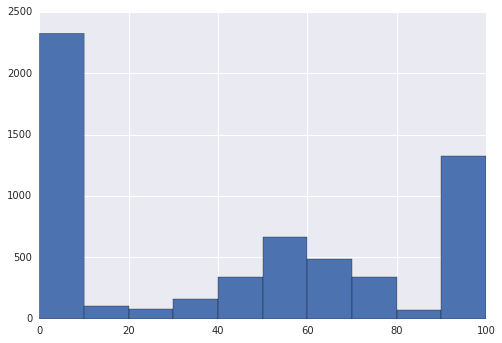

time: 4min 7s


In [16]:
%autoreload
keys = ['wiki+googleart', 'wga']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)
    

In [17]:
%autoreload
dataset_names = ['wiki+googleart', 'wga']
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=85, max_sim=111, 
                discard_exaclty_matched_dates=True,
                min_k=2)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=85, max_sim=111, 
                discard_exaclty_matched_dates=False,
                min_k=2)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_wga', 'artist_id_wiki+googleart'])
    appended = appended[results_df.columns]
else:
    appended = results_df_transposed

# appended = results_df
output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches.csv'.format('-'.join(dataset_names))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
appended


manually checked pairs: 365
count: 0
0
manually checked pairs: 365
count: 0
0
Total rows 0


""


time: 3.11 s


In [18]:
# FIX duplicates in WGA
# big_comp_wiki_googleart

NameError: name 'big_comp_wiki_googleart' is not defined

time: 25.9 ms


In [19]:
# artists_with_years_dict['googleart']['url_wiki'] = artists_with_years_dict['googleart']['url_wiki'].apply(lambda x: 'https://en.wikipedia.org/wiki/ernest_meissonier' if x == 'http://en.wikipedia.org/wiki/jean-louis-ernest_meissonier' else x)


ids = list()
for comp in big_comp_wiki_googleart:
    comp = sorted(list(comp))
    ids.extend(comp[:2])
artists_with_years_dict['wiki+googleart'][['artist_name', 'years_range', 'url_wiki']].iloc[ids]

NameError: name 'big_comp_wiki_googleart' is not defined

time: 33.6 ms


In [43]:
dataset_names = ['wiki+googleart', 'wga']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim)
artists_with_years_dict['+'.join(dataset_names)] = merged_df
merged_df.to_hdf('artists_{}.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
merged_df


  1%|          | 45/5906 [00:00<00:13, 449.42it/s]

connected_components at the beginning: 10633



  1%|▏         | 126/9377 [00:00<00:07, 1254.22it/s]

connected_components: 9377



100%|██████████| 9377/9377 [00:07<00:00, 1336.89it/s]


,artist_ids,artist_name,bio,names,page_url,url_wiki,works_count,years,years_bio,years_range,years_work,artist_id
artist_id,,,,,,,,,,,,
3d,[3d],3d,NaN,"[robert del naja, 3d]",NaN,https://en.wikipedia.org/wiki/robert_del_naja,10,"[1984.0, 1986.0, 1988.0, 1991.0, 1994.0, 1983.0]","[1966, 2099]","[1966, 2099]","[1983.0, 1994.0]",3d
a-y-jackson,[a-y-jackson],a y jackson,NaN,"[a y jackson, alexander young jackson, a.y. ja...",NaN,https://en.wikipedia.org/wiki/a._y._jackson,30,"[1920.0, 1953.0, 1921.0, 1923.0, 1926.0, 1927....","[1882, 1974]","[1882, 1974]","[1910.0, 1953.0]",a-y-jackson
m0632pc,"[m0632pc, abanindranath-tagore]",abanindranath tagore,Abanindranath Tagore was the principal artist ...,[abanindranath tagore],[https://www.google.com/culturalinstitute/beta...,https://en.wikipedia.org/wiki/abanindranath_ta...,138,"[1920.0, 1924.0, 1927.0, 1929.0, 1930.0, 1906....","[1871, 1951]","[1871, 1951]","[1897.0, 1939.0]",m0632pc
abdul-qader-al-raes,[abdul-qader-al-raes],abdul qader al raes,NaN,[abdul qader al raes],NaN,https://en.wikipedia.org/wiki/abdul_qader_al_rais,17,"[2008.0, 2011.0, 1995.0, 1998.0, 2007.0]","[1951, 2099]","[1951, 2099]","[1995.0, 2011.0]",abdul-qader-al-raes
abdullah-suriosubroto,[abdullah-suriosubroto],abdullah suriosubroto,NaN,[abdullah suriosubroto],NaN,https://id.wikipedia.org/wiki/abdullah_suriosu...,18,NaN,"[1878, 1941]","[1878, 1941]",NaN,abdullah-suriosubroto
abidin-dino,[abidin-dino],abidin dino,NaN,[abidin dino],NaN,https://en.wikipedia.org/wiki/abidin_dino,54,"[1955.0, 1956.0, 1989.0, 1990.0, 1961.0, 1930....","[1913, 1993]","[1913, 1993]","[1930.0, 1993.0]",abidin-dino
abraham-manievich,[abraham-manievich],abraham manievich,NaN,"[abraham manievich, абрам маневич]",NaN,https://en.wikipedia.org/wiki/abraham_a._manie...,53,"[1921.0, 1923.0, 1925.0, 1905.0, 1929.0, 1930....","[1881, 1941]","[1881, 1941]","[1905.0, 1939.0]",abraham-manievich
abraham-palatnik,[abraham-palatnik],abraham palatnik,NaN,[abraham palatnik],NaN,https://en.wikipedia.org/wiki/abraham_palatnik,3,[1965.0],"[1928, 2099]","[1928, 2099]","[1965.0, 1965.0]",abraham-palatnik
"strij, abraham van, i, (1753-1826)","[strij, abraham van, i, (1753-1826), abraham-v...",abraham van strij,NaN,"[abraham van strij, strij, abraham van, i]",NaN,https://en.wikipedia.org/wiki/abraham_van_strij,45,"[1800.0, 1825.0, 1810.0]","[1753, 1826]","[1753, 1826]","[1800.0, 1825.0]","strij, abraham van, i, (1753-1826)"


time: 20.3 s


In [21]:
artists_with_years_dict.keys()

['wiki',
 'wga',
 'wiki+googleart+wga',
 'wiki+googleart',
 'googleart',
 'meisterwerke']

time: 5.16 ms


In [22]:
dataset_names = ['wiki', 'googleart', 'wga', 'wiki+googleart+wga']
for key in dataset_names:
    print '{}: {} unique artists'.format(key, len(artists_with_years_dict[key]))

wiki: 2270 unique artists
googleart: 4380 unique artists
wga: 4727 unique artists
wiki+googleart+wga: 9377 unique artists
time: 3.99 ms


wiki+googleart+wga-meisterwerke



  0%|          | 0/9377 [00:00<?, ?it/s]

Num taks: 9377



  0%|          | 37/9377 [00:03<3:33:43,  1.37s/it][Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.7s

  1%|          | 69/9377 [00:04<28:20,  5.47it/s][Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    1.4s

  1%|          | 107/9377 [00:04<06:07, 25.23it/s][Parallel(n_jobs=16)]: Done  81 tasks      | elapsed:    2.3s

  2%|▏         | 159/9377 [00:07<05:27, 28.12it/s][Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    4.9s

  2%|▏         | 219/9377 [00:09<03:42, 41.12it/s][Parallel(n_jobs=16)]: Done 189 tasks      | elapsed:    6.3s

  3%|▎         | 286/9377 [00:10<04:54, 30.90it/s][Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:    8.1s

  4%|▍         | 363/9377 [00:12<04:49, 31.15it/s][Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:   10.0s

  5%|▍         | 448/9377 [00:14<03:10, 46.80it/s][Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:   11.9s

  6%|▌         | 539/9377 [00:17<05:12, 28.27it/s][Parallel(n_jobs=16)]: Done 513 tasks      | 

  9%|▉         | 875/9377 [00:25<03:29, 40.58it/s][Parallel(n_jobs=16)]: Done 850 tasks      | elapsed:   22.8s

 11%|█         | 1007/9377 [00:28<03:30, 39.75it/s][Parallel(n_jobs=16)]: Done 981 tasks      | elapsed:   26.3s

 12%|█▏        | 1148/9377 [00:32<03:18, 41.41it/s][Parallel(n_jobs=16)]: Done 1120 tasks      | elapsed:   29.7s

 14%|█▍        | 1295/9377 [00:36<03:12, 41.88it/s][Parallel(n_jobs=16)]: Done 1269 tasks      | elapsed:   33.6s

 16%|█▌        | 1455/9377 [00:40<03:24, 38.65it/s][Parallel(n_jobs=16)]: Done 1426 tasks      | elapsed:   38.2s

 17%|█▋        | 1623/9377 [00:45<03:13, 40.14it/s][Parallel(n_jobs=16)]: Done 1593 tasks      | elapsed:   42.5s



 19%|█▉        | 1797/9377 [00:49<03:04, 41.12it/s][Parallel(n_jobs=16)]: Done 1768 tasks      | elapsed:   46.8s

 21%|██        | 1978/9377 [00:53<03:06, 39.58it/s][Parallel(n_jobs=16)]: Done 1953 tasks      | elapsed:   51.3s

 23%|██▎       | 2176/9377 [00:58<02:46, 43.21it/s][Parallel(n_jobs=16)]: Done 2146 tasks      | elapsed:   56.1s

 25%|██▌       | 2375/9377 [01:04<04:22, 26.71it/s][Parallel(n_jobs=16)]: Done 2349 tasks      | elapsed:  1.0min

 26%|██▌       | 2458/9377 [01:05<02:21, 49.01it/s]


 28%|██▊       | 2590/9377 [01:09<02:34, 43.87it/s][Parallel(n_jobs=16)]: Done 2560 tasks      | elapsed:  1.1min

 30%|██▉       | 2806/9377 [01:14<02:13, 49.34it/s][Parallel(n_jobs=16)]: Done 2781 tasks      | elapsed:  1.2min

 32%|███▏      | 3040/9377 [01:20<02:11, 48.10it/s][Parallel(n_jobs=16)]: Done 3010 tasks      | elapsed:  1.3min

 35%|███▍      | 3276/9377 [01:25<02:16, 44.59it/s][Parallel(n_jobs=16)]: Done 3249 tasks      | elapsed:  1.4min

 35%|███▌      | 3299/9377 [01:26<02:20, 43.40it/s]


 38%|███▊      | 3526/9377 [01:32<02:30, 38.78it/s][Parallel(n_jobs=16)]: Done 3496 tasks      | elapsed:  1.5min

 40%|████      | 3777/9377 [01:38<03:00, 31.07it/s][Parallel(n_jobs=16)]: Done 3753 tasks      | elapsed:  1.6min

 43%|████▎     | 4045/9377 [01:44<02:27, 36.07it/s][Parallel(n_jobs=16)]: Done 4018 tasks      | elapsed:  1.7min

 44%|████▍     | 4155/9377 [01:47<02:00, 43.45it/s]


 46%|████▌     | 4323/9377 [01:51<01:59, 42.39it/s][Parallel(n_jobs=16)]: Done 4293 tasks      | elapsed:  1.8min

 49%|████▉     | 4599/9377 [01:57<01:52, 42.36it/s][Parallel(n_jobs=16)]: Done 4576 tasks      | elapsed:  1.9min

 52%|█████▏    | 4896/9377 [02:04<01:25, 52.45it/s][Parallel(n_jobs=16)]: Done 4869 tasks      | elapsed:  2.0min

 54%|█████▎    | 5025/9377 [02:07<01:33, 46.62it/s]


 55%|█████▌    | 5198/9377 [02:11<01:32, 45.09it/s][Parallel(n_jobs=16)]: Done 5170 tasks      | elapsed:  2.2min

 59%|█████▉    | 5510/9377 [02:19<02:10, 29.74it/s][Parallel(n_jobs=16)]: Done 5481 tasks      | elapsed:  2.3min

 62%|██████▏   | 5827/9377 [02:26<01:10, 50.56it/s][Parallel(n_jobs=16)]: Done 5800 tasks      | elapsed:  2.4min

 63%|██████▎   | 5893/9377 [02:28<01:20, 43.26it/s]


 66%|██████▌   | 6154/9377 [02:34<01:25, 37.51it/s][Parallel(n_jobs=16)]: Done 6129 tasks      | elapsed:  2.5min

 69%|██████▉   | 6496/9377 [02:42<01:11, 40.45it/s][Parallel(n_jobs=16)]: Done 6466 tasks      | elapsed:  2.7min

 72%|███████▏  | 6759/9377 [02:48<00:59, 44.13it/s]


 73%|███████▎  | 6839/9377 [02:50<01:04, 39.31it/s][Parallel(n_jobs=16)]: Done 6813 tasks      | elapsed:  2.8min

 77%|███████▋  | 7197/9377 [02:58<00:48, 45.08it/s][Parallel(n_jobs=16)]: Done 7168 tasks      | elapsed:  2.9min

 81%|████████  | 7559/9377 [03:06<00:37, 48.78it/s][Parallel(n_jobs=16)]: Done 7533 tasks      | elapsed:  3.1min

 81%|████████▏ | 7624/9377 [03:08<00:42, 40.91it/s]


 85%|████████▍ | 7934/9377 [03:15<00:28, 49.78it/s][Parallel(n_jobs=16)]: Done 7906 tasks      | elapsed:  3.2min

 89%|████████▊ | 8317/9377 [03:24<00:27, 39.18it/s][Parallel(n_jobs=16)]: Done 8289 tasks      | elapsed:  3.4min

 91%|█████████ | 8501/9377 [03:29<00:20, 43.37it/s]


 93%|█████████▎| 8705/9377 [03:33<00:16, 41.15it/s][Parallel(n_jobs=16)]: Done 8680 tasks      | elapsed:  3.5min

 97%|█████████▋| 9106/9377 [03:43<00:05, 45.45it/s][Parallel(n_jobs=16)]: Done 9081 tasks      | elapsed:  3.7min

100%|██████████| 9377/9377 [03:49<00:00, 40.91it/s][Parallel(n_jobs=16)]: Done 9377 out of 9377 | elapsed:  3.8min finished


Sim matrix saved to sim_matrix_wiki+googleart+wga-meisterwerke.npy
(9377, 2165)


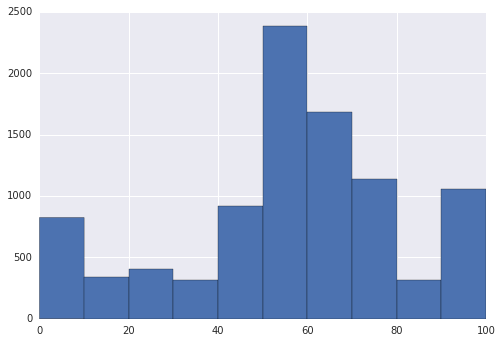

time: 3min 52s


In [28]:
##### MEISTERWERKE #######

%autoreload
keys = ['wiki+googleart+wga', 'meisterwerke']
get_sim_matrix_and_plot(keys, force=True, n_jobs=16)

In [38]:
##### MEISTERWERKE #######
%autoreload
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
results_df = check_pairs(dataset_names, 
                transpose=False,
                min_sim=100, max_sim=101, 
                discard_exaclty_matched_dates=True,
                min_k=2,
                min_total_works_count=10)

if len(results_df):
    results_df['year_diff'] = results_df.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)
results_df

# Transposed
results_df_transposed = check_pairs(dataset_names, 
                transpose=True,
                min_sim=100, max_sim=101, 
                discard_exaclty_matched_dates=True,
                min_k=2,
                min_total_works_count=10)
if len(results_df_transposed):
    results_df_transposed['year_diff'] = results_df_transposed.apply(lambda x: [abs(x['dates_' + dataset_names[0]][i] - x['dates_' + dataset_names[1]][i]) for i in range(2)], axis=1)

if len(results_df):
    appended = results_df.append(results_df_transposed, ignore_index=True)
    appended = appended.drop_duplicates(['artist_id_' + key for key in dataset_names])
    appended = appended[results_df.columns]
else:
    appended = results_df_transposed


output_path = '/export/home/asanakoy/workspace/dataset_merger/aggregated/{}_check_matches0.csv'.format('-'.join(dataset_names))
appended.to_csv(output_path, encoding='utf-8')
print 'Total rows', len(appended)
print dataset_names
appended
# TODO: geenrate for sabine

count: 48
48
count: 26
26
Total rows 69
['wiki+googleart+wga', 'meisterwerke']


,score,names_wiki+googleart+wga,dates_wiki+googleart+wga,names_meisterwerke,dates_meisterwerke,is_same,artist_id_wiki+googleart+wga,artist_id_meisterwerke,idx,total_works_count,year_diff
0,100.0,"[canaletto, giovanni antonio canal]","[1697, 1768]",[canaletto (ii) (werkstatt)],"[1750.0, 1750.0]",True,canaletto,canaletto (ii) (werkstatt),"(298, 295)",447,"[53.0, 18.0]"
1,100.0,"[canaletto, giovanni antonio canal]","[1697, 1768]",[canaletto (i)],"[1723.0, 1766.0]",True,canaletto,canaletto (i),"(298, 293)",547,"[26.0, 2.0]"
2,100.0,"[canaletto, giovanni antonio canal]","[1697, 1768]",[canaletto (ii)],"[1740.0, 1779.0]",True,canaletto,canaletto (ii),"(298, 294)",583,"[43.0, 11.0]"
3,100.0,"[dieric bouts, dirk bouts]","[1415, 1577.0]","[bouts, dieric]","[1450.0, 1475.0]",True,dirk-bouts,"bouts, dieric","(469, 225)",69,"[35.0, 102.0]"
4,100.0,"[dieric bouts, dirk bouts]","[1415, 1577.0]","[bouts, dieric (nachfolger)]","[1500.0, 1500.0]",True,dirk-bouts,"bouts, dieric (nachfolger)","(469, 226)",56,"[85.0, 77.0]"
5,100.0,"[lippi, fra filippo, fra' filippo lippi, filip...","[1406, 1469]","[lippi, fra filippo (und gehilfen)]","[1450.0, 1450.0]",True,m03kb6h,"lippi, fra filippo (und gehilfen)","(617, 1070)",272,"[44.0, 19.0]"
6,100.0,"[lippi, fra filippo, fra' filippo lippi, filip...","[1406, 1469]","[lippi, fra filippo]","[1426.0, 1489.0]",True,m03kb6h,"lippi, fra filippo","(617, 1069)",416,"[20.0, 20.0]"
7,100.0,"[vasari, giorgio, giorgio vasari]","[1511, 1574]","[vasari, giorgio (gehilfen)]","[1550.0, 1550.0]",True,m0pvnq,"vasari, giorgio (gehilfen)","(775, 2026)",245,"[39.0, 24.0]"
8,100.0,"[vasari, giorgio, giorgio vasari]","[1511, 1574]","[vasari, giorgio]","[1540.0, 1566.0]",True,m0pvnq,"vasari, giorgio","(775, 2025)",245,"[29.0, 8.0]"
9,100.0,"[giotto, giotto di bondone]","[1266, 1337]",[giotto di bondone],"[1294.0, 1350.0]",True,giotto,giotto di bondone,"(777, 660)",924,"[28.0, 13.0]"


time: 2.46 s


In [47]:
##### MEISTERWERKE #######
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

# artists_with_years_dict['+'.join(dataset_names)] = get_merged_artists_df(dataset_names, dfs_to_merge, sim)


assert len(dataset_names) == len(dfs_to_merge)
assert sim.shape == (len(dfs_to_merge[0]), len(dfs_to_merge[1])), sim.shape


manually_checked_matches_path = '{}_manually_corrected_matches.csv'.format(
    '-'.join(dataset_names))
if os.path.exists(manually_checked_matches_path):
    manually_checked_matches_df = pd.read_csv(manually_checked_matches_path, index_col=0,
                                              encoding='utf-8')
    sim = fix_sim_matrix(dataset_names,
                                dfs_to_merge,
                                sim,
                                manually_checked_matches_df)

connected_components = find_connected_components(sim, min_sim=100)
big_comp = [x for x in connected_components if len(x) > 2]
small_comp = [x for x in connected_components if len(x) <= 2]
connected_components = small_comp + [{el} for x in big_comp for el in x]

big_comp = [x for x in connected_components if len(x) > 2]
assert len(big_comp) == 0, len(big_comp)

  1%|          | 83/9377 [00:00<00:11, 824.67it/s]

connected_components at the beginning: 11542


100%|██████████| 9377/9377 [00:08<00:00, 1120.71it/s]

connected_components: 10630
time: 8.42 s


In [48]:
# TODO: filter out big components. Recheck them
# TODO: merge images wga wiki. googleart
big_comp

[]

time: 5.53 ms


In [50]:
%autoreload
dataset_names = ['wiki+googleart+wga', 'meisterwerke']
sim = sim_matrix['-'.join(dataset_names)]
dfs_to_merge = [artists_with_years_dict[key] for key in dataset_names]

merged_df = get_merged_artists_df(dataset_names, dfs_to_merge, sim, split_big_components=True)
artists_with_years_dict['+'.join(dataset_names)] = merged_df
merged_df.to_hdf('artists_{}_alpha.hdf5'.format('+'.join(dataset_names)), 'df', mode='w')
merged_df.to_csv('artists_{}_alpha.csv'.format('+'.join(dataset_names)), encoding='utf-8')
merged_df

  1%|          | 77/9377 [00:00<00:12, 769.87it/s]

connected_components at the beginning: 11542


  1%|▏         | 139/10714 [00:00<00:07, 1389.82it/s]

connected_components: 10630


100%|██████████| 10714/10714 [00:06<00:00, 1566.54it/s]


,artist_ids,artist_name,bio,names,page_url,url_wiki,works_count,years,years_bio,years_range,years_work,artist_id
artist_id,,,,,,,,,,,,
3d,[3d],3d,NaN,"[robert del naja, 3d]",NaN,https://en.wikipedia.org/wiki/robert_del_naja,10,"[1984.0, 1986.0, 1988.0, 1991.0, 1994.0, 1983.0]","[1966, 2099]","[1966, 2099]","[1983.0, 1994.0]",3d
a-y-jackson,[a-y-jackson],a y jackson,NaN,"[a y jackson, alexander young jackson, a.y. ja...",NaN,https://en.wikipedia.org/wiki/a._y._jackson,30,"[1920.0, 1953.0, 1921.0, 1923.0, 1926.0, 1927....","[1882, 1974]","[1882, 1974]","[1910.0, 1953.0]",a-y-jackson
m0632pc,"[m0632pc, abanindranath-tagore]",abanindranath tagore,Abanindranath Tagore was the principal artist ...,[abanindranath tagore],[https://www.google.com/culturalinstitute/beta...,https://en.wikipedia.org/wiki/abanindranath_ta...,138,"[1920.0, 1924.0, 1927.0, 1929.0, 1930.0, 1938....","[1871, 1951]","[1871, 1951]","[1897.0, 1939.0]",m0632pc
abdul-qader-al-raes,[abdul-qader-al-raes],abdul qader al raes,NaN,[abdul qader al raes],NaN,https://en.wikipedia.org/wiki/abdul_qader_al_rais,17,"[2008.0, 2011.0, 1998.0, 1995.0, 2007.0]","[1951, 2099]","[1951, 2099]","[1995.0, 2011.0]",abdul-qader-al-raes
abdullah-suriosubroto,[abdullah-suriosubroto],abdullah suriosubroto,NaN,[abdullah suriosubroto],NaN,https://id.wikipedia.org/wiki/abdullah_suriosu...,18,NaN,"[1878, 1941]","[1878, 1941]",NaN,abdullah-suriosubroto
abidin-dino,[abidin-dino],abidin dino,NaN,[abidin dino],NaN,https://en.wikipedia.org/wiki/abidin_dino,54,"[1955.0, 1956.0, 1989.0, 1990.0, 1961.0, 1930....","[1913, 1993]","[1913, 1993]","[1930.0, 1993.0]",abidin-dino
abraham-manievich,[abraham-manievich],abraham manievich,NaN,"[abraham manievich, абрам маневич]",NaN,https://en.wikipedia.org/wiki/abraham_a._manie...,53,"[1921.0, 1923.0, 1925.0, 1937.0, 1929.0, 1930....","[1881, 1941]","[1881, 1941]","[1905.0, 1939.0]",abraham-manievich
abraham-palatnik,[abraham-palatnik],abraham palatnik,NaN,[abraham palatnik],NaN,https://en.wikipedia.org/wiki/abraham_palatnik,3,[1965.0],"[1928, 2099]","[1928, 2099]","[1965.0, 1965.0]",abraham-palatnik
"strij, abraham van, i, (1753-1826)","[strij, abraham van, i, (1753-1826), abraham-v...",abraham van strij,NaN,"[abraham van strij, strij, abraham van, i]",NaN,https://en.wikipedia.org/wiki/abraham_van_strij,45,"[1800.0, 1825.0, 1810.0]","[1753, 1826]","[1753, 1826]","[1800.0, 1825.0]","strij, abraham van, i, (1753-1826)"


time: 21.8 s
